**Group 21:** Grégoire Bellan, Benjamin Cohen, Victor Manach, Hugues René-Bazin

In [2]:
%config InlineBackend.figure_formats = ['retina']

import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn library
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Library for Neural Networks
from keras.layers import Dense, Activation
from keras.models import Sequential

# Load data

In [3]:
data = pd.read_csv('./data/SeoulBikeData.csv', encoding='latin1')

In [4]:
data.Date = pd.to_datetime(data.Date, dayfirst=True)

# Pre-processing

## Change the values of some attributes

- Conversion of functionning days from ``Yes`` and ``No`` to 0 and 1
> Yes $\rightarrow$0, No $\rightarrow$1
- Conversion of the seasons from String to integers between 0 and 3
> Winter $\rightarrow$0, Spring $\rightarrow$1, Summer $\rightarrow$2 and Autumn $\rightarrow$3
- Conversion of holidays from ``No Holiday`` and ``Holiday`` to 0 and 1
> No Holiday $\rightarrow$0, Holiday $\rightarrow$1

In [5]:
data['Functioning Day'] = (data['Functioning Day']=='Yes').astype(int)

In [6]:
data['Holiday'] = (data['Holiday']=='Holiday').astype(int)

In [7]:
data = data.replace({'Seasons': {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3}})

In [8]:
data = data.set_index(data.Date).drop('Date', axis=1)

## Create train and test sets 

In [9]:
X, y = data.drop('Rented Bike Count', axis=1), data['Rented Bike Count']

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.33)

In [11]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# List to compare the performance of the different models 
performance_list = []

# PCA for dimension reduction

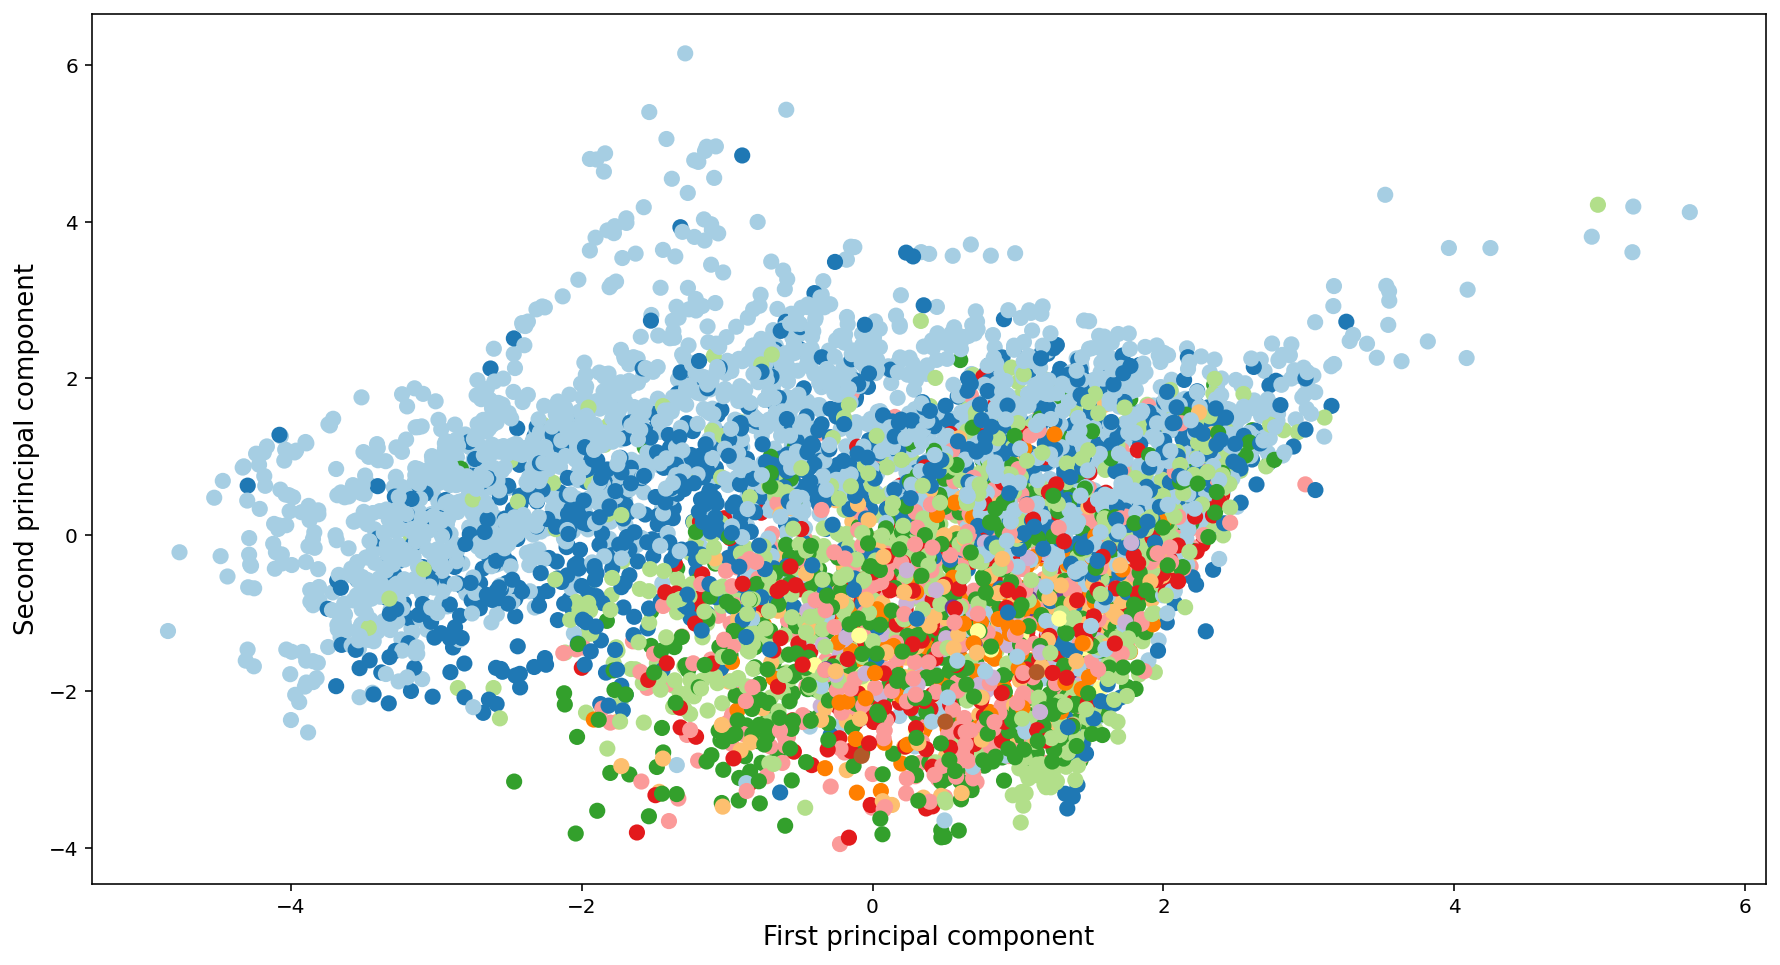

In [12]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(x_train)

plt.figure(figsize=(15,8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train, s=50, cmap=plt.cm.Paired)
plt.xlabel('First principal component', size=13)
plt.ylabel('Second principal component', size=13)
plt.show()

On this plot, the different colors represent the different target values (the number of rented bikes). Therefore, we can see that the values are all overlapping and therefore SVR will most likely perform badly for this task. Therefore, we will start with Regression trees (and Random Forest to improve the results). 

# Regression tree

Regression trees often perform well on large datasets. The difficulty is to tune the parameters to find the best values in order to avoid overfitting on the train set and still perform well on the test set.

In [13]:
%%time
depth_list = np.arange(8,20)
decision_parameters = { 'max_depth': depth_list, 'min_samples_leaf': np.arange(1,10)}
reg_tree = GridSearchCV(DecisionTreeRegressor(), decision_parameters,cv=7)
reg_tree.fit(x_train, y_train)

CPU times: user 16.4 s, sys: 124 ms, total: 16.6 s
Wall time: 17.4 s


GridSearchCV(cv=7, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [14]:
rt_train, rt_test = reg_tree.score(x_train, y_train), cross_val_score(reg_tree,x_test,y_test).mean()
performance_list.append(['Regression Tree CV',rt_train, rt_test])
print('Train accuracy: {} \nTest accuracy: {} \nBest parameters: {}'.format(rt_train, rt_test, reg_tree.best_params_))

Train accuracy: 0.8879529949337304 
Test accuracy: 0.7815805892544722 
Best parameters: {'max_depth': 11, 'min_samples_leaf': 9}


We use the ``cross_val_score`` function to compute the score on several folds of the test set and then take the mean to have a more precise test accuracy.

We have limited the depth of the tree in order to avoid overfitting. In addition, we have noticed that tuning the ``min_sample_leaf`` parameter gave us better results.\
To visualise the performance of the model, we plot the true value of the rented bikes count and the predicted value. The plot is shown below (we plot only 100 values, otherwise there are too many points on the plot).

In [15]:
y_pred_tree = reg_tree.predict(x_test)

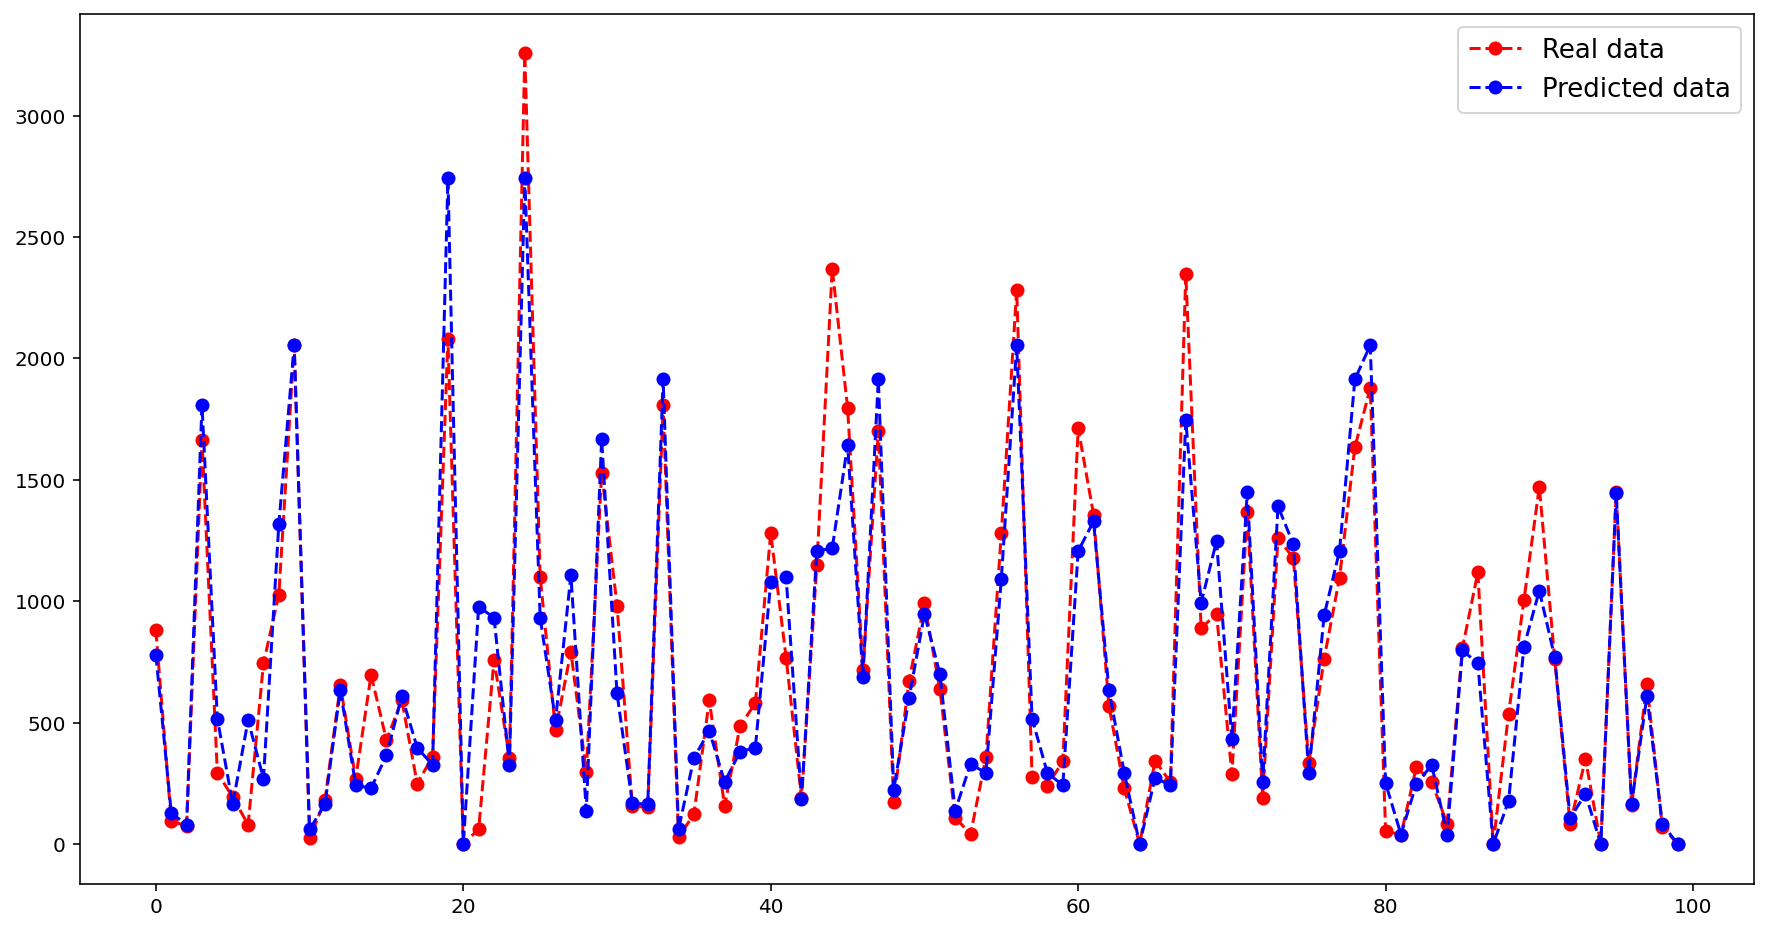

In [16]:
plt.figure(figsize=(15,8))
plt.plot(y_test.values[100:200], color = 'r', marker='o', linestyle='--', label='Real data')
plt.plot(y_pred_tree[100:200], color = 'b', marker='o', linestyle='--', label='Predicted data')
plt.legend(fontsize=13)
plt.show()

Most of the time, the value predicted by the model is lower than the true value (especially when the true value is large).\
To improve the model, we will now use Random Forest Regression

# Random Forest regression

In [17]:
%%time
reg_forest = RandomForestRegressor()
reg_forest.fit(x_train, y_train)

CPU times: user 2.3 s, sys: 23.8 ms, total: 2.33 s
Wall time: 2.33 s


RandomForestRegressor()

In [19]:
train_score_forest, test_score_forest = reg_forest.score(x_train, y_train), cross_val_score(reg_forest,x_train,y_train).mean()
performance_list.append(['Random Forest Regressor', train_score_forest, test_score_forest])
print('Train accuracy: {} \nTest accuracy: {}'.format(train_score_forest, test_score_forest))

Train accuracy: 0.9813506977914169 
Test accuracy: 0.8662454820651891


## Cross Validation 

The accuracy obtained is already quite good but we will use cross-validation to see we can find the value of the parameters to improve the test score without too much overfitting.

In [20]:
%%time 
tuned_parameters = {'max_depth':np.arange(22,27), 'min_samples_leaf' : np.arange(1,3)} 
rf_cv = GridSearchCV(RandomForestRegressor(), tuned_parameters)
rf_cv.fit(x_train, y_train)

CPU times: user 1min 32s, sys: 1.16 s, total: 1min 33s
Wall time: 1min 34s


GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([22, 23, 24, 25, 26]),
                         'min_samples_leaf': array([1, 2])})

In [21]:
train_score_cv, test_score_cv = rf_cv.score(x_train, y_train), cross_val_score(rf_cv,x_train,y_train).mean()
print('Train accuracy: {} \nTest accuracy: {} \nBest parameters: {}'.format(train_score_cv, test_score_cv, rf_cv.best_params_))

Train accuracy: 0.981477274549932 
Test accuracy: 0.8665051717559648 
Best parameters: {'max_depth': 23, 'min_samples_leaf': 1}


The time to find the best parameters and train the model is quite long (around 2min, even with a grid with few values per parameter) and the results are not better than the one we have found previously.

In [22]:
y_pred_forest = reg_forest.predict(x_test)

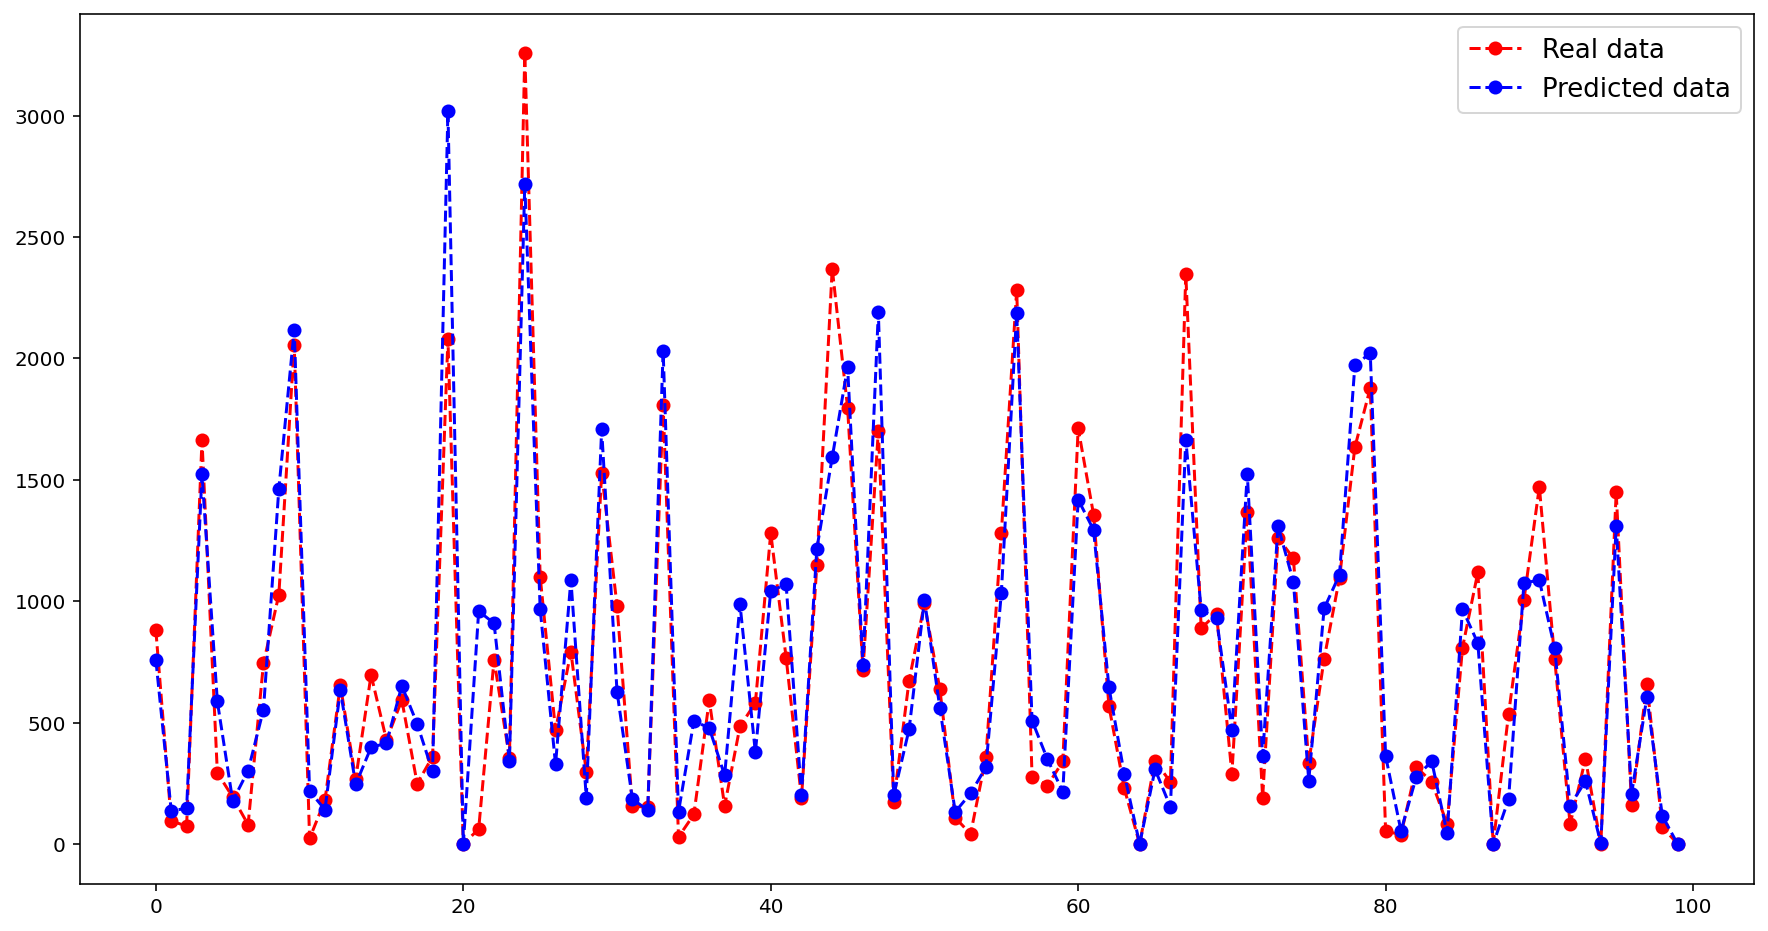

In [23]:
plt.figure(figsize=(15,8))
plt.plot(y_test.values[100:200], color = 'r', marker='o', linestyle='--', label='Real data')
plt.plot(y_pred_forest[100:200], color = 'b', marker='o', linestyle='--', label='Predicted data')
plt.legend(fontsize=13)
plt.show()

Compared to the regression tree, the values predicted are often closer to the true values, but still often lower.

## Summary of the methods 
 
So far, we used have used the following models:
- Regression Tree
- Random Forest Regression

In [24]:
print('Method name  || Training Score || Testing score')
for i,j,k in performance_list:
    print('{} || {} || {}'.format(i,round(j,5),round(k,5)))

Method name  || Training Score || Testing score
Regression Tree CV || 0.88795 || 0.78158
Random Forest Regressor || 0.98135 || 0.86625


We can see that the algorithm that give the best score on the testing set is the ```RandomForestRegressor```. The score on the train set is very high that might indicate that there is some overfitting.

Next, we will use a neural network to determine if we can have better performance on the test set without too much overfitting.

# Neural network

**Architecture**\
There are 12 features in the data set and we want to predict a single value. In addition, we use a linear activation function for the output layer because it is a regression task. For the other paramters, we have tested different combination (change the number of hidden layers, the number of neurons, the loss function and the optimizer) and the following architecture is the one that gave us the best results.

In [25]:
model = Sequential()

model.add(Dense(units = 128, activation='relu', input_dim=12))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 1, activation='linear'))


model.compile(loss='mean_squared_error', optimizer='adam')

In [26]:
%%time
history = model.fit(x_train, y_train, batch_size = 25, epochs = 150, validation_data=(x_test, y_test), verbose=0)

CPU times: user 1min 32s, sys: 14.5 s, total: 1min 46s
Wall time: 1min 13s


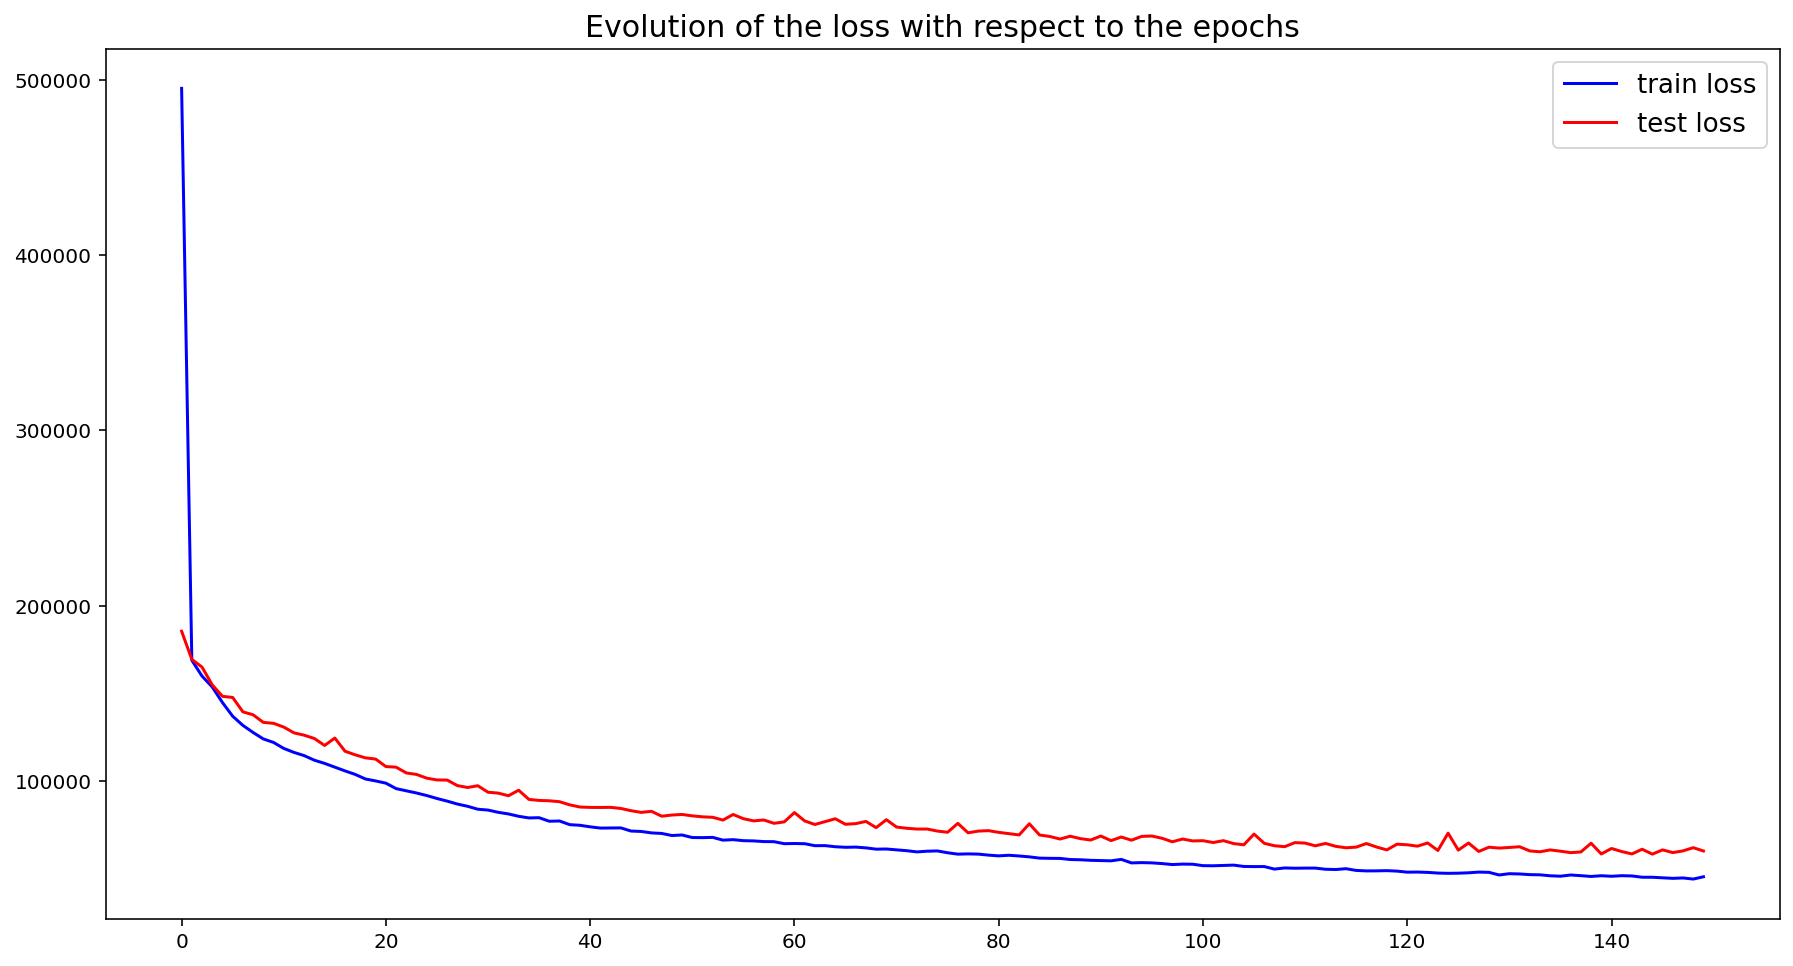

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(15,8))
plt.plot(loss, c='b', label='train loss')
plt.plot(val_loss, c='r', label='test loss')
plt.title('Evolution of the loss with respect to the epochs', size=15)
plt.legend(fontsize=13)
plt.show()

In [28]:
y_pred_NN = model.predict(x_test)

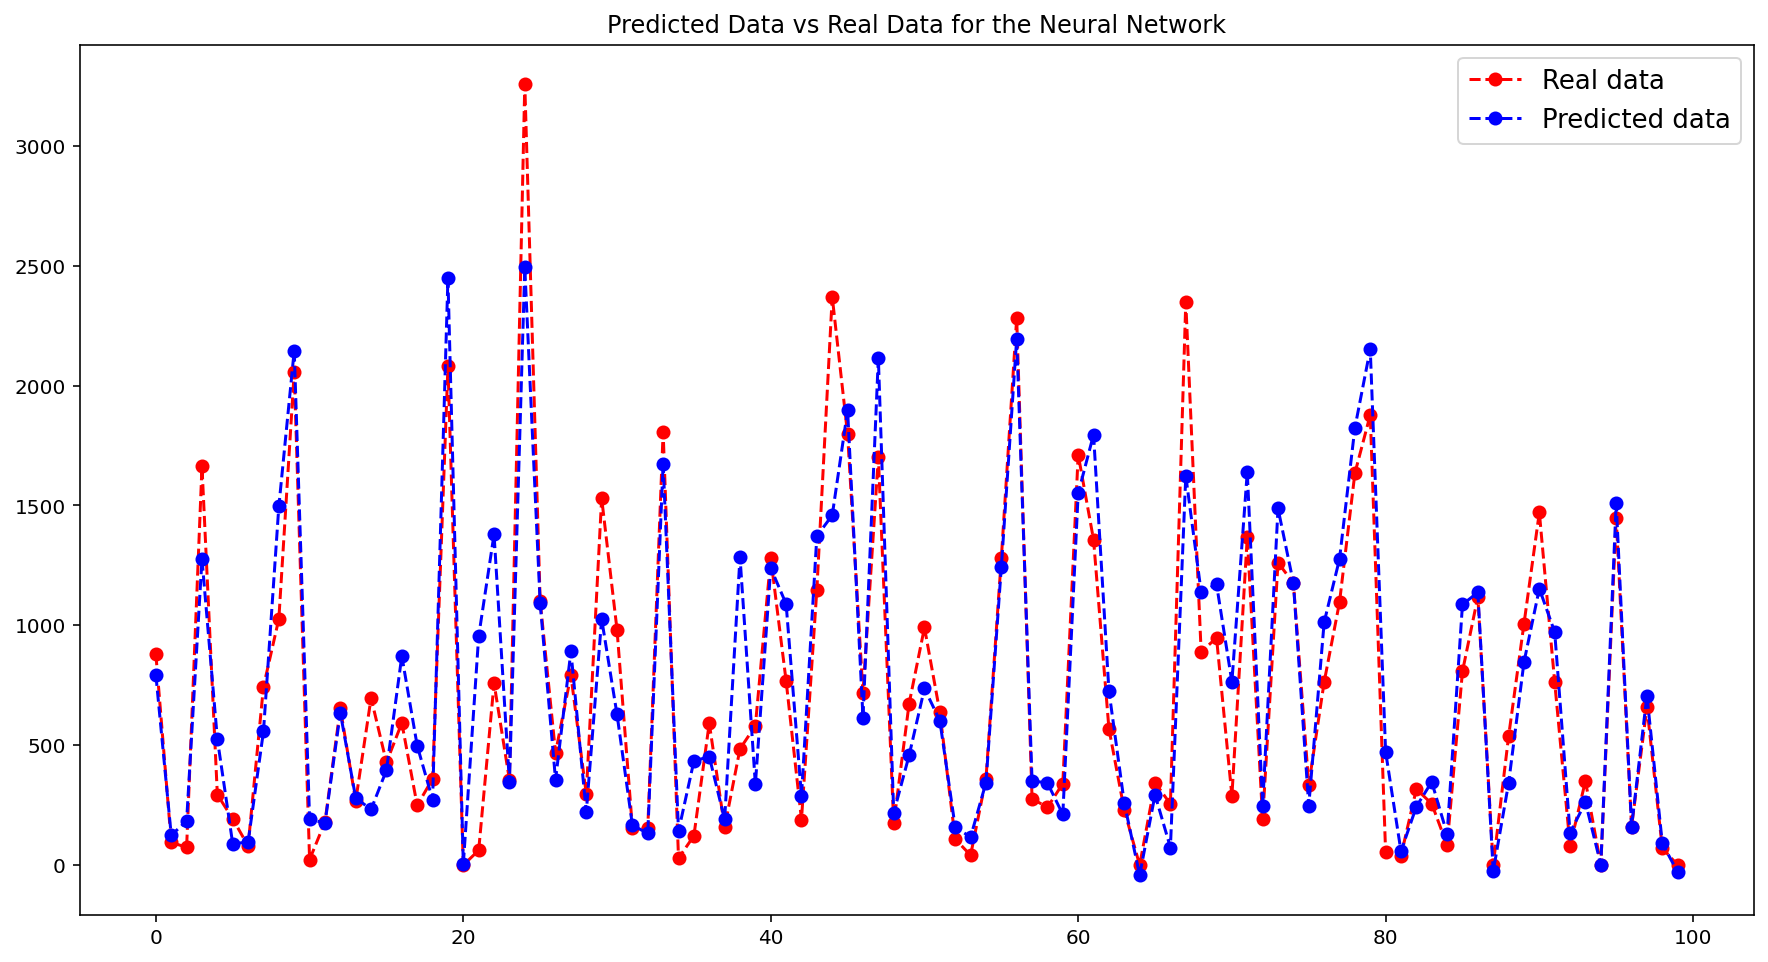

In [29]:
plt.figure(figsize=(15,8))
plt.plot(y_test.values[100:200], color = 'r', marker='o', linestyle='--', label = 'Real data')
plt.plot(y_pred_NN[100:200], color = 'b', marker='o', linestyle='--', label = 'Predicted data')
plt.legend(fontsize=13)
plt.title('Predicted Data vs Real Data for the Neural Network')
plt.show()

This model is better at predicting large values, but still seem to perform worse than the Random Forest Regressor (the predicted values seem further away from the true values with the neural network)

**Neural Network analysis**\
We have a loss that decreases very fast on the testing set and on the training set as well. By increasing the epochs, the test loss stagnates, so we use ``epochs=150`` to have a quite precise model and quite fast to train.\
For the regression task, the accuracy (between 0 and 1) cannot be computed and we only have the mean squared error between the prediction of the model and the true values.

# Comparison between the Random Forest Regression and the Neural Network 

**In order to compare those to algorithms we will compare the mean squarre error between the predicted value by the model and the true value of y_test.**

In [30]:
random_forest_mse = mean_squared_error(y_test, y_pred_forest)
NN_mse = mean_squared_error(y_test, y_pred_NN)
print('Method         || MSE \nRandom Forest  || {} \nNeural Network || {}'.format(round(random_forest_mse,2), round(NN_mse,2)))

Method         || MSE 
Random Forest  || 55647.38 
Neural Network || 60078.07


Therefore, the Random Forest Regressor performs a bit better at this task.

# Conclusion 

To sum up, the Random Forest Regressor is the best performing model for this regression task. As there were quite a lot of overlapping in the target values (rented bikes count) we count not use SVR and linear regressors. Although, the performance of the neural network is a bit worse than the one of the Random Forest, the neural network still seems to perform better at predicting large values, which can be interesting to keep in mind.